# Content-Based-Filtering

In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

## TMDB Movie Data

In [2]:
credits = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_movies.csv')

In [5]:
credits.sample(1)

,movie_id,title,cast,crew
3723,17663,Anne of Green Gables,"[{""cast_id"": 1, ""character"": ""Anne Shirley"", ""...","[{""credit_id"": ""52fe473d9251416c7509267f"", ""de..."


In [6]:
movies.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
3317,7500000,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,34341,"[{""id"": 6075, ""name"": ""sport""}]",en,Men with Brooms,A witty and clever comedy that follows four lo...,1.369528,[],"[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}]",2002-09-20,4245870,102.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Men with Brooms,4.5,7


In [15]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

## Data Exploration

In [7]:
# Rename column movie_id to id and then merging the two dataframe together on id
credits = credits.rename({'movie_id': 'id'}, axis = 1)
df = movies.merge(credits, on = 'id')

In [11]:
df = df.drop_duplicates()

In [12]:
df.shape

(4803, 23)

In [13]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

There are a lot of null values for the columns *homepage* and *tagline*. Fortunately those columns are not very important in terms of the metadata for the movies because *homepage* is just link to the movie and *tagline* is a catchphrase for a movie. Instead of *tagline* it will be much more useful to use the overview of the movies to see if movies are similar or not

In [16]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title_x                  object
vote_average            float64
vote_count                int64
title_y                  object
cast                     object
crew                     object
dtype: object

In [59]:
# Get Earlies and Latest Release Dates
df['release_date'] = pd.to_datetime(df['release_date'])
print("Earliest Release Date in dataset: " + str(min(df.release_date)))
print("Latest Release Date in dataset: " + str(max(df.release_date)))

Earliest Release Date in dataset: 1916-09-04 00:00:00
Latest Release Date in dataset: 2017-02-03 00:00:00


Text(0, 0.5, 'frequency')

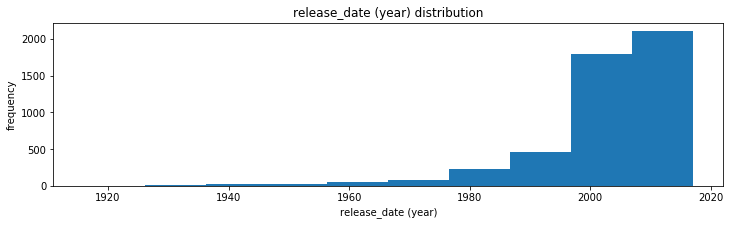

In [63]:
# Distribution of release years 
fig = plt.figure(figsize = (12,3))
plt.hist(df.release_date.dt.year)
plt.title('release_date (year) distribution')
plt.xlabel('release_date (year)')
plt.ylabel('frequency')

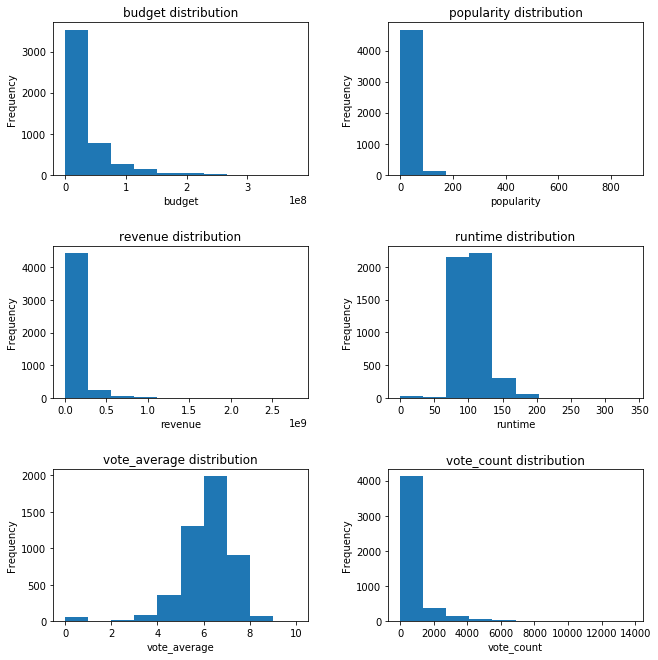

In [45]:
continuous_features = ['budget', 'popularity', 'revenue', 'runtime',
                      'vote_average', 'vote_count']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = [10 ,10])
fig.tight_layout(pad = 5.0)
axes = axes.flatten()
position = 0
for feature in continuous_features:
    axes[position].hist(df[feature])
    axes[position].set_title(feature + " distribution")
    axes[position].set_xlabel(feature)
    axes[position].set_ylabel("Frequency")
    position = position + 1

In [53]:
df.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
3526,5500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 80, ""nam...",NaN,9277,"[{""id"": 520, ""name"": ""chicago""}, {""id"": 622, ""...",en,The Sting,Set in the 1930's this intricate caper deals w...,28.500913,"[{""name"": ""Universal Pictures"", ""id"": 33}]",...,129.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,...all it takes is a little confidence.,The Sting,7.9,622,The Sting,"[{""cast_id"": 1, ""character"": ""Henry Gondorff"",...","[{""credit_id"": ""574dba43c3a36839030001ba"", ""de..."


In [55]:
df.iloc[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

The following columns in the dataset contain lists of dictionaries as their values: *genres, keywords, production_companies, production_countries, spoken_languages, cast, crew*. 

We will extract the important medadata from these dictionaries and have the values in a list. 

For example, for the genre column we want the final output to look like this: [action, comedy].

We will define a couple of helper functions that will extract the necessary metadata for our dataset columns

First lets take a look at the different dictionaries and which key value we need to extract

In [72]:
dict_features = ['genres', 'keywords', 'production_companies', 
                'production_countries', 'spoken_languages',
                'cast', 'crew']

for i in dict_features:
    print("========================== "+ i + " =========================")
    print(df[i].iloc[0])

========================== genres =========================
[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
========================== keywords =========================
[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]
=======

* **genres** - name
* **keywords** - name
* **production_companies** - name
* **production_countries** - name
* **spoken_languages** - name
* **cast** - name

We can write a function that takes all the values from the *name* key. However, as we can see from the above output, there are a lot of values for some of the features such as *cast* and *crew*. We do not want to include all those features as we will have a super high-dimension matrix that will be very sparse aswell. 

For cast we can just take the top N values because usually the people with the most screentime are listed first on the cast lists.

For crew we will just fetch the Director of the movie.

In [ ]:
def extract_name(dict_column):
    if isinstance(dict_column, list):
        metadata = [i['name'] for i in dict_column]
        return metadata
    return []

